In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

import statsmodels.api as sm

In [2]:
def format_x_axis(ax):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.tick_params(axis='x', labelrotation=45)

# ARMA and friends

The models we describe in this notebook can be called *classical models*, as they have been worked out at the beginnig of the previous century and therefore have a longer tradition than more recent statistical models.

A time-series process can be either stationary or non-stationary. Stationarity is defined by the following three characteristics:

1. Finite *variation*
2. Constant *mean*
3. Constant *variation*

Many time-series exhibit trends and seasonality, while many others assume stationarity. If a time-series is stationary, its mean and standard deviation stays constant over time. This implies that the time-series has no trend and no cyclic variability. Therefore the removal of irregular components, trends, and seasonal fluctuations is an intrinsic aspect of applying classical models. The models then forecast what's left after this removal.

To apply these classical models, a time-series usually should be decomposed into different components. This is usually done as follows:

1. Test for stationarity
2. Differencing (if stationarity is detected)
3. Fit model and forecast
4. Add back the trends and seasonality

## Moving Average

The *Moving Average* (MA), the unweighted mean over a period of $k$ points, is defined as follows:

$$
MA = \frac{1}{k}\Sigma_{i=1}^{k}x_i
$$ 

where $x_i$ is the observed time-series.

The MA can be used to smooth out a time-series, thereby removing noise and periodic fluctuations that occur in the short term, effectively working as a low-pass filter. We have seen this in our [`demo_univariate_modelling`-notebook](demo_univariate_modelling.ipynb').

In [3]:
df = pd.read_csv('../data/btc.csv', names=['date','value'], skiprows=1, parse_dates=[0])
df['avg'] = df['value'].rolling(30).mean()
#df.info()
df.head()

,date,value,avg
0,2017-12-31,14156.400391,NaN
1,2018-01-01,13657.200195,NaN
2,2018-01-02,14982.099609,NaN
3,2018-01-03,15201.000000,NaN
4,2018-01-04,15599.200195,NaN


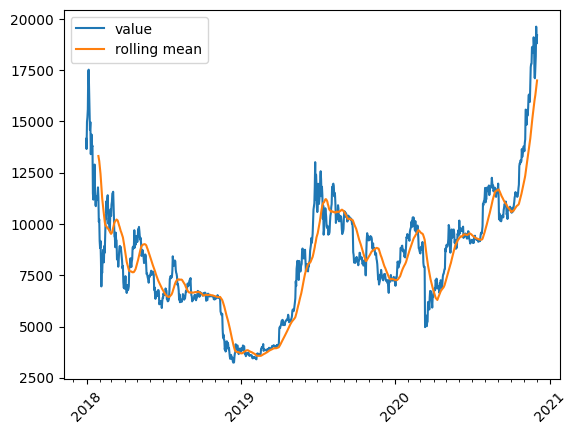

In [4]:
fig, ax = plt.subplots()
format_x_axis(ax)
ax.plot(df['date'], df['value'], label='value')
ax.plot(df['date'], df['avg'], label='rolling mean')

ax.legend()
plt.show()

We can also use MA to forecast into the future as well. The time-series is a linear regression of the current value of the series against observed values. For this to work, we can use the [*Autoregressive Model*](https://en.wikipedia.org/wiki/Autoregressive_model), which regresses the variable on its own lagged values: the current value of the value is driven by immediately preceding values using a linear combination. This way we get an *autoregressive–moving-average* or ARMA-model. 

The Autoregressive (AR) part of the ARMA model uses the relationship between an observation and a number of lagged (previous) observations to predict future values. The Moving Average (MA) part of the ARMA model uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

## ARMA model
The ARMA-model consists of two types of lagged values, one for the autoregressive component and the other fot he moving average component. Therefore, we write $ARMA(p,q)$, where $p$ indicates the order of the autoregression, and $q$ the order of the moving average. Thus

$$
ARMA(p,q):x_t = c + \epsilon_t + \Sigma_{i=1}^{p}\phi_ix_{t-i} + \Sigma_{i=0}^{q}\Phi_i\epsilon_{t-i}
$$

where  $c$ is a constant, $\phi_i$ and $\Phi_i$ are *model parameters* and $\epsilon_t$ represents noise. ARMA assumes that the series is stationary. 

To demonstrate ARMA in statsmodels, we need to use the [`ARIMA`-class](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html), with the differencing-parameter set to zero (0). We'll get to this in a moment. 

In [5]:
# First we define a method to plot our results.

def plot_model_results(ax, data, models=[], names=[], colors=[], steps=30, color='red'):
    assert len(models) == len(names)
    assert len(models) == len(colors)
    ax.plot(data, label='Observed Data', color='blue')
    ax.axvline(n, color='gray', linestyle='dotted', label='Forecast Start')
    
    for i, model in enumerate(models):
        forecast = model.get_forecast(steps=steps)
        preds = forecast.predicted_mean    
        conf = forecast.conf_int()
        idx = np.arange(n, n + steps)
        
        #plot the forecasts:
        ax.plot(idx, preds, label=f"{names[i]} Forecast", color=colors[i], linestyle='dashed')
        # Plot the confidence Intervals
        ax.fill_between(idx, conf[:, 0], conf[:, 1], color=colors[i], alpha=0.2)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

In [6]:
# Let's generate some seasonal data (sinusoidal with noise)
np.random.seed(42)
seasonality = 20 # 20-period seasonality
n = 100
x = np.arange(n)
seasonal_data = 10 * np.sin(2 * np.pi * x / seasonality) + np.random.normal(0, 2, size=n)  

In [7]:
arma_model = sm.tsa.ARIMA(seasonal_data, order=(2, 0, 1))
arma_results = arma_model.fit()
arma_results.summary()

/Users/baba/.venv/bioinf/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/baba/.venv/bioinf/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -262.234
Date:                Wed, 26 Feb 2025   AIC                            534.468
Time:                        19:00:57   BIC                            547.494
Sample:                             0   HQIC                           539.740
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3482      3.146     -0.111      0.912      -6.515       5.819
ar.L1          0.0302      0.189      0.160      0.873      -0.341       0.401
ar.L2          0.7539      0.170      4.436      0.000       0.421       1.087
ma.L1          0.9241      0.143      6.447      0.000       0.643       1.205
sigma2        10.9105      1.587      6.876      0.000       7.801      14.020
===================================================================================
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):                 2.61
Prob(Q):                              0.21   Prob(JB):                         0.27
Heteroskedasticity (H):               1.15   Skew:                            -0.39
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

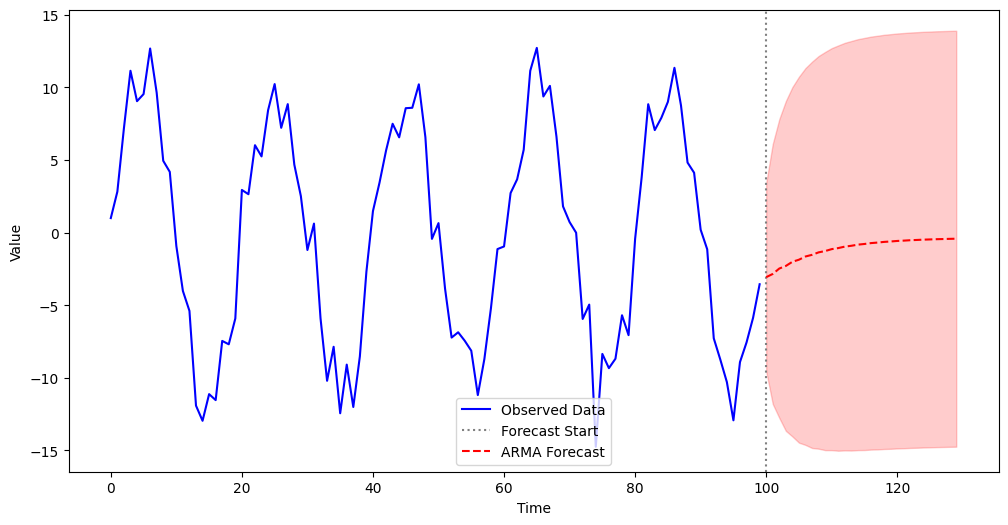

In [8]:
fig,ax = plt.subplots(figsize=(12,6))
plot_model_results(ax, seasonal_data, models=[arma_results], names=['ARMA'], colors=['red'])
plt.legend(loc='best')
plt.show()

## The ARIMA model

A generalisation of the ARMA model is the Autoregressive *Integrated* Moving Average model. It is especially used for non-stationary data, for it includes data pre-processing step to make the data more stationary. This is done by replacing values by subtracting the immediate past values, a transformation called *differencing*. The model integration is parametrized by $d$, which is the number of times differences have been taken between current and previous values. So, an ARIMA model is capable of capturing trands but not seasonality.

Note that in te cell below we use the same class as above, only with different values for the `order`-parameter.

In [9]:
arima_model = sm.tsa.ARIMA(seasonal_data, order=(2, 1, 1))
arima_results = arima_model.fit()
arima_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -255.677
Date:                Wed, 26 Feb 2025   AIC                            519.353
Time:                        19:00:57   BIC                            529.734
Sample:                             0   HQIC                           523.553
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3356      0.312      1.076      0.282      -0.276       0.947
ar.L2          0.3020      0.117      2.586      0.010       0.073       0.531
ma.L1         -0.2809      0.360     -0.781      0.435      -0.986       0.424
sigma2        10.2209      1.555      6.571      0.000       7.172      13.269
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.83   Prob(JB):                         0.89
Heteroskedasticity (H):               1.04   Skew:                            -0.02
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

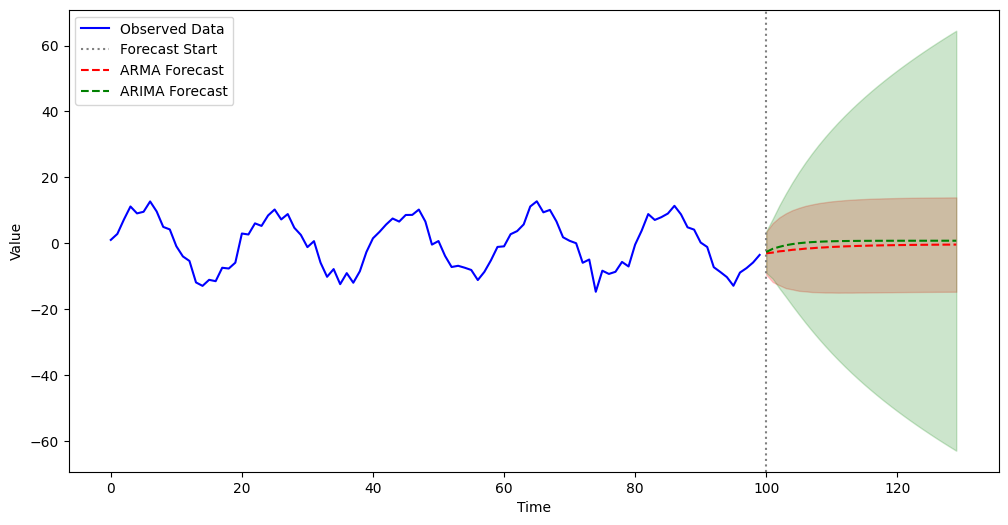

In [10]:
fig,ax = plt.subplots(figsize=(12,6))
plot_model_results(ax, seasonal_data, models=[arma_results, arima_results], names=['ARMA', 'ARIMA'], colors=['red','green'])
plt.legend()
plt.show()

## The SARIMA model

To account for the seasonality of the data, we have another generalisation of the ARMA model, called SARIMA (we didn't make this up). SARIMO models are usually stated as $ARIMA(p,d,q)(P,D,Q)m$, where

- $m$ denotes the number of periods in a season
- $P,D,Q$ parametrize the autoregressive, integration, and moving average component of the *sesonal part*
- $p,d,q$ are the parameters of the ARIMA-part, that we discussed above.

For SARIMA, we have another class that we can use, [`SARIMAX`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX).

In [11]:
sarima_model = sm.tsa.SARIMAX(seasonal_data, order=(2, 1, 1), seasonal_order=(1, 1, 1, 20))
sarima_results = sarima_model.fit()
sarima_results.summary()

/Users/baba/.venv/bioinf/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97049D+00    |proj g|=  9.46680D-02

At iterate    5    f=  1.82356D+00    |proj g|=  1.40250D-01

At iterate   10    f=  1.79753D+00    |proj g|=  9.39460D-03

At iterate   15    f=  1.79501D+00    |proj g|=  3.82068D-03

At iterate   20    f=  1.79473D+00    |proj g|=  1.17759D-03

At iterate   25    f=  1.79470D+00    |proj g|=  3.60695D-04

At iterate   30    f=  1.79469D+00    |proj g|=  3.19951D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.79469D+00    |proj g|=  8.23461D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     59      2     0     0   8.235D-06   1.795D+00
  F =   1.7946928887373681     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 20)   Log Likelihood                -179.469
Date:                            Wed, 26 Feb 2025   AIC                            370.939
Time:                                    19:00:59   BIC                            385.155
Sample:                                         0   HQIC                           376.634
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0563      0.131     -0.430      0.667      -0.313       0.200
ar.L2         -0.0222      0.134     -0.166      0.868      -0.284       0.240
ma.L1         -0.9984      2.167     -0.461      0.645      -5.246       3.249
ar.S.L20      -0.0570      0.308     -0.185      0.853      -0.660       0.546
ma.S.L20      -0.9989    166.308     -0.006      0.995    -326.957     324.959
sigma2         3.3465    554.260      0.006      0.995   -1082.983    1089.676
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.94   Prob(JB):                         0.89
Heteroskedasticity (H):               0.85   Skew:                            -0.12
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

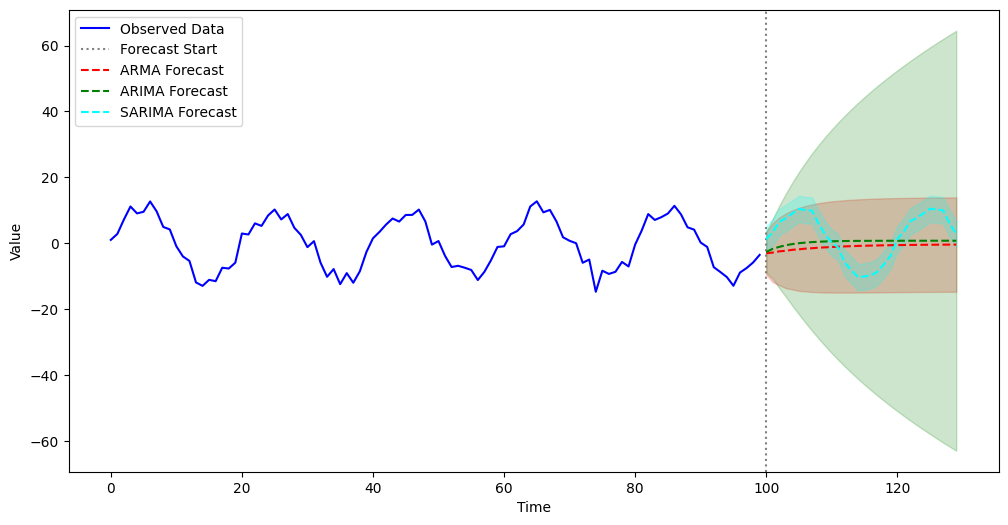

In [12]:
fig,ax = plt.subplots(figsize=(12,6))
plot_model_results(ax, seasonal_data, 
                   models=[arma_results, arima_results, sarima_results],
                   names=['ARMA', 'ARIMA', 'SARIMA'],
                   colors=['red', 'green', 'cyan'])
plt.legend()
plt.show()

From the plot above, you can conclude that for this seasonal data, SARIMA is by far the better predictor.